# Project Proposal

## Title: Influences of Employee Attrition



## Introduction:


Within the human resources (HR) department of companies, there is a record kept of every employee that has ever worked in said company, some data including their job role, level of education and job satisfaction, to name a few. One of the most important variables that is kept track of in these records is the attrition of the employees, whether or not an employee ended up leaving the company. HR data analysts can compile this data and analyze it to help the management team determine what makes for an ideal employee to hire, and how to retain employees. They can do this by looking at what factors cause employees to stay in the said company and which factors generally cause employees to leave. The data set our group is analyzing is fictional, yet realistic, and was created by an HR data analyst for a company who was interested in determining the factors relating to the employee attrition.  

For our group project, we would like to propose the following research question:

#### “Can we determine whether or not there will be employee attrition based on the hourly rate of pay and time spent working for a company of an employee?”


## Preliminary exploratory data analysis:

Below are the steps to tidying our data by isolating important variables and eliminating irrelevant variables, no missing values present. To ensure no bias in our analysis, we also created a standardization recipe. 

In [1]:
install.packages("kknn")
install.packages("themis")
library(tidyverse)
library(repr)
library(kknn)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_

In [2]:
attrition_data<-read.csv ("https://raw.githubusercontent.com/wenshanli1231/DSCI-Group-Project/main/Employee-Attrition.csv")
attrition_data

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,⋯,2,80,1,6,0,3,6,2,0,3
49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,⋯,4,80,0,17,3,2,9,6,0,8
34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,⋯,1,80,0,6,3,4,4,3,1,2


In [3]:
attrition_data <- attrition_data |>
    select( Attrition, HourlyRate, YearsAtCompany)

attrition_data <- attrition_data |>
        mutate(Attrition = as_factor(Attrition))

In [4]:
attrition_split <- initial_split(attrition_data, prop = 0.75, strata = Attrition)
attrition_train <- training(attrition_split)
attrition_test <- testing(attrition_split) 

In [5]:
set.seed(10)


 #attrition_recipe <- recipe(Attrition~ HourlyRate + YearsAtCompany, data = attrition_train) |>
    # step_scale(all_predictors()) |>
    # step_center(all_predictors())


 #attrition_data_balanced <- attrition_recipe |>  
      #                       prep() |> 
     #                        bake(attrition_train)
rare_attrition <- bind_rows(
        filter(attrition_train, Attrition == "No"),
        attrition_train |> filter(Attrition == "Yes") |> slice_head(n=3)) |>
        select(Attrition, HourlyRate, YearsAtCompany)


attrition_recipe <- recipe (Attrition~ HourlyRate + YearsAtCompany , data= rare_attrition ) |>
    step_upsample(Attrition, over_ratio = 1, skip = FALSE) 

attrition_data_balanced <- attrition_recipe |>  
                            prep() |> 
                           bake(attrition_train)

attrition_recipe_upsampled <- recipe(Attrition~ HourlyRate + YearsAtCompany , data= attrition_data_balanced) |> 
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 



In [6]:
yeses <- attrition_data_balanced |>
    group_by (Attrition) |>
    count()
yeses

Attrition,n
<fct>,<int>
Yes,924
No,924


### Below is a summary of our tidied Employee Attrition data in one table 

In [7]:
attrition_table <- attrition_data_balanced |>
        group_by(Attrition) |>
        summarize( 
            mean_HourlyRate = mean(HourlyRate), 
            mean_YearsAtCompany = mean(YearsAtCompany), 
            count = n(), 
            count_blanks = sum(is.na(Attrition))
        )

attrition_table

Attrition,mean_HourlyRate,mean_YearsAtCompany,count,count_blanks
<fct>,<dbl>,<dbl>,<int>,<int>
Yes,66.16450,5.455628,924,0
No,66.83117,7.283550,924,0


### Below is a relevant visualization that will be used in our exploration

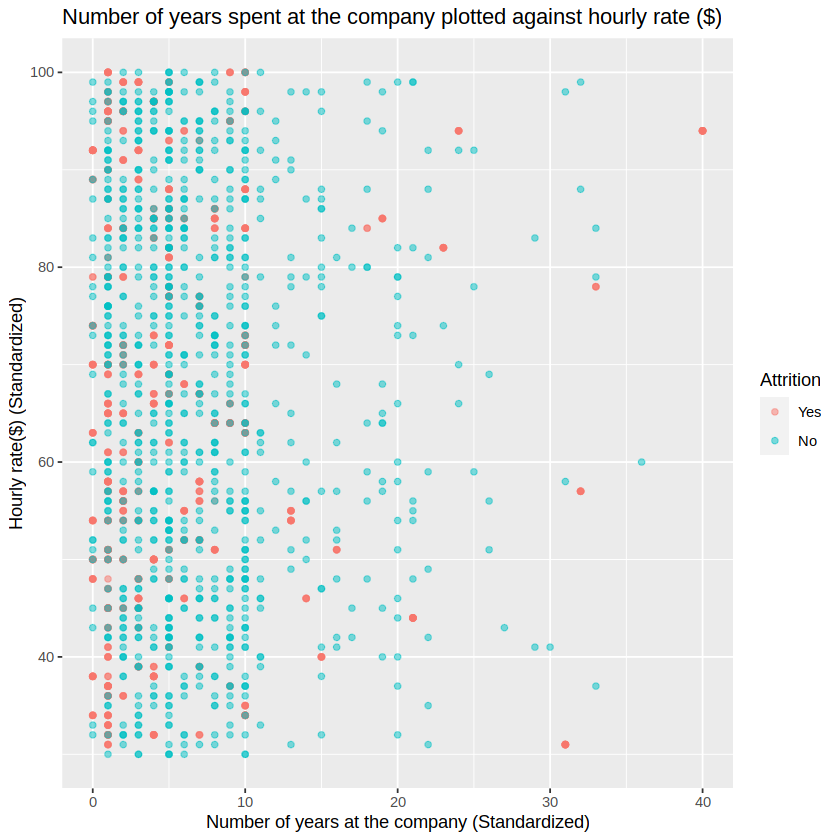

In [8]:
attrition_plot <- ggplot(attrition_data_balanced, aes(x = YearsAtCompany, y = HourlyRate, colour = Attrition)) + 
            geom_point(alpha = 0.5) +
            xlab("Number of years at the company (Standardized)") +
            ylab("Hourly rate($) (Standardized)") +
            labs(title = "Number of years spent at the company plotted against hourly rate ($)")
            
attrition_plot


Above is a visualization of our our categorical variable with the 2 predictor variables. We have made the transparency of the points 50% to increase visibility of all points. With such design, we can see that there are many similar points as indicated by the darker points. The scatter plot portrays a pattern where there is significantly more Non attrition employees and most employees at the company stayed for less than 10 years. 

## Method: 

We will conduct our data analysis by first tidying our data, and then selecting the columns of the variables we are interested in: the hourly rate earned, years worked at company, and attrition. We chose these variables because we imagine a strong correlation to employee attrition. It is commonly observed that high compensations incentivize employees to stay while the opposite for lower wages. Years working at the company also influence their decisions to stay or leave at the company since they might enjoy their higher position, their team, work environment or benefits received. On the other hand, new employees might not be as attached. Our analysis will determine if these variables are actually correlated with attrition and we plan to visualize this through a scatter plot with the years worked and hourly rate on the axis and the points colored by attrition. This way we can try and identify any patterns or trends.



## Expected outcomes and significance:

From this data, we expect to find an association between our established predictor variables and employee attrition, in that there will be less attrition to individuals with a higher hourly rate of pay and larger amount spent working for the company. Our data analysis will bring value to the management team in making strategic decisions on hiring the best candidates and factors to consider to retain talent. Future research could explore other categories, such as level of education, business traveling, and more to create a strong system to predict attrition and perform measures to prevent such results.  


## Tuning To Find Optimal Value of K

In [9]:
knn_tuned <- nearest_neighbor(weight_func = "rectangular",neighbors=tune())|>
                set_engine("kknn")|>
                set_mode("classification")
knn_tuned

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [10]:
attrition_vfold <- vfold_cv(attrition_data_balanced,v=5,strata=Attrition)


In [36]:
knn_result <- workflow()|>
                add_recipe(attrition_recipe_upsampled)|>
                add_model(knn_tuned) |>
                tune_grid(resamples=attrition_vfold,grid=10)|>
                collect_metrics()
knn_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8674295,5,0.01135506,Preprocessor1_Model1
2,roc_auc,binary,0.8719794,5,0.01260653,Preprocessor1_Model1
3,accuracy,binary,0.8100764,5,0.01241317,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,roc_auc,binary,0.7516532,5,0.01215109,Preprocessor1_Model8
14,accuracy,binary,0.6910223,5,0.01282600,Preprocessor1_Model9
14,roc_auc,binary,0.7389305,5,0.01252761,Preprocessor1_Model9


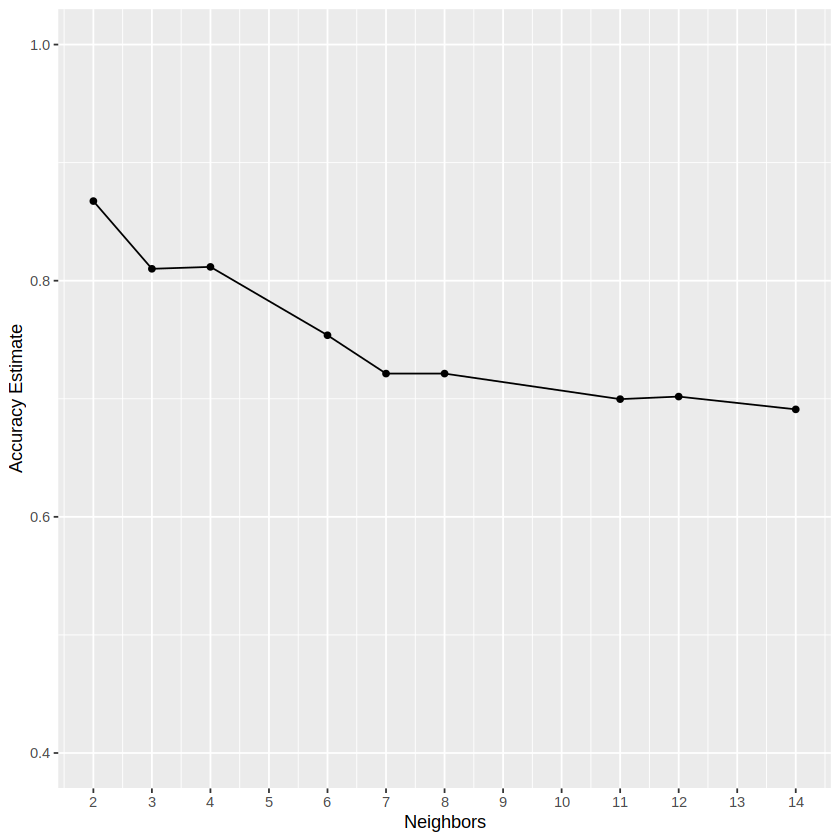

In [47]:
accuracies <- knn_result|>
                filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies,aes(x=neighbors,y=mean))+
                        geom_point()+
                        geom_line()+
                        labs(x = "Neighbors", y = "Accuracy Estimate") +
                        scale_x_continuous(breaks = seq(0, 14, by = 1)) + 
                        scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k

We performed the elbow method in determing our K value. Since the line graph levels out at around K=7 neighbors, we will be using K=7 in our model specification. 

In [48]:
knn_spec <- nearest_neighbor(weight_func="rectangular",neighbors=7)|>
                set_engine("kknn")|>
                set_mode("classification")

In [49]:
attrition_fit <- workflow()|>
                add_recipe(attrition_recipe_upsampled)|>
                add_model(knn_spec)|>
                fit(data=attrition_train)
attrition_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1653043
Best kernel: rectangular
Best k: 7

In [50]:
attrition_test_predictions <- predict(attrition_fit,attrition_test)|>
                            bind_cols(attrition_test)
attrition_test_predictions

.pred_class,Attrition,HourlyRate,YearsAtCompany
<fct>,<fct>,<int>,<int>
No,Yes,94,6
No,No,81,1
Yes,No,96,1
⋮,⋮,⋮,⋮
No,No,73,5
No,No,30,4
No,No,63,9


In [51]:
attrition_prediction_accuracy <- attrition_test_predictions|>
                                    metrics(truth=Attrition,estimate=.pred_class)
attrition_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.81300813
kap,binary,0.03458082


In [52]:
at_mat <- attrition_test_predictions|>
                conf_mat(truth=Attrition,estimate=.pred_class)
at_mat

          Truth
Prediction Yes  No
       Yes   4  13
       No   56 296

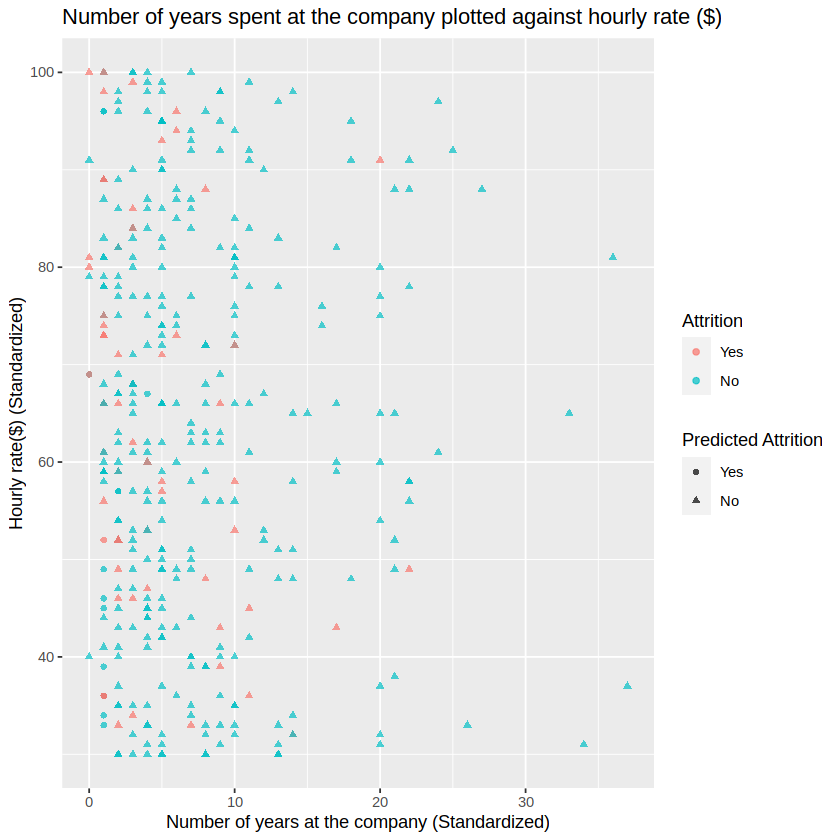

In [53]:
attrition_prediction_plot <- ggplot(attrition_test_predictions, aes(x = YearsAtCompany, y = HourlyRate, colour = Attrition, shape = .pred_class)) + 
            geom_point(alpha = 0.7) +
            xlab("Number of years at the company (Standardized)") +
            ylab("Hourly rate($) (Standardized)") +
            labs(title = "Number of years spent at the company plotted against hourly rate ($)",shape="Predicted Attrition")
            
attrition_prediction_plot

Our final visualization compares the prediction with original data. Through shaping and colouring our points, red circles indicate a True positive, while Blue triangle represenets a True Negative. From the Scatter plot, we can see that the true positive attritions all have left the company within 

# Discussion:


Through a comprehensive analysis of the data, our model concluded an 81.3% accuracy for predicting attrition among employees, and portrayed a pattern that most attrition occurs for employees working at the company for less than 5 yr, with an hourly rate less than $60. This indicates that since they have not been at the company for a long time, they are less attached and more willing to leave. While the 81.3% accuracy is acceptable in the case of employee attrition, the confusion matrix provided us with a more in depth analysis on how this percentage is composed. When comparing the attrition predictions independently between Yes-Attrition and No-Attrition, we can see that in predicting attrition, our model predicted more false negatives (56) than true positives (4). On the other hand, when predicting no attrition, there are significantly more true negatives (296) than false positives (13). After careful review of the model, it is concluded that since our original data set was very imbalanced, only upsampling the testing data and performing prediction on the imbalanced training data makes the model still imbalance. Therefore, for future improvements, we would recommend to upsample the training data set as well prior to performing the predictions in order to obtain a more comparable result.  


Before starting this analysis, we predicted that overall, employees who were receiving a higher hourly rate of pay and who had been at a company for longer would show lower rates of attrition. From our data, we could not see a clear correlation in the data between these variables, mainly due to the fact that there were so many more data points stating employee attrition as opposed to no employee attrition. This, still, was unexpected for us to see and ended up causing problems when building our model, creating many false negatives. 


There are many reasons why being able to predict employee attrition would be impactful. It would be beneficial for companies to be able to predict employee attrition because while a certain amount of turnover is inevitable, too much turnover can be detrimental to a company. To most companies, employees are a valuable asset and training new employees to replace someone’s role can be costly. In a study about employee attrition (Srivastava, D.K., Nair, P), they mention that it can cost a company about 30-400% of an employee’s annual salary to replace them. Finding what influences employee attrition can allow companies to implement changes and provide incentives for employees to stay. Therefore if employee attrition could be predicted, it would make a positive impact on companies as well as employees.


More in-depth analysis into the factors that determine employee attrition could be conducted. Our investigation only explored hourly pay and years spent working at the company. However, other research conducted on the same topic also considered factors such as department (Jain, Kumar, et al). This could lead to a further analysis in which attrition rates between departments are compared to analyze what differing factors between departments could be influencing attrition.  Additionally, we initially believed that a higher hourly rate would affect attrition, yet there was no clear indication of this. Why might this be the case could be worth investigating, alongside exploring if other compensation related factors such as raises and bonuses play a role. Lastly, one could investigate how attrition rates of a company and compare to the industry as a whole. Are there industries where attrition is higher or lower, and how does the company of analysis match up with those standards? Ultimately, the reasons for which a  person decides to stay at a company or not varies, so there are numerous ways in which to extend the investigation into attrition rates. 


## References:

Jain, Praphula Kumar, et al. “Explaining and predicting employees’ attrition: A machine learning approach.” SN Applied Sciences, vol. 2, no. 4, 2020, https://doi.org/10.1007/s42452-020-2519-4.  [MLA 9] Jain, Kumar, et al

Srivastava, D.K., Nair, P. (2018). Employee Attrition Analysis Using Predictive Techniques. In: Satapathy, S., Joshi, A. (eds) Information and Communication Technology for Intelligent Systems (ICTIS 2017) - Volume 1. ICTIS 2017. Smart Innovation, Systems and Technologies, vol 83. Springer, Cham. https://doi.org/10.1007/978-3-319-63673-3_35

Patel, Prashant. “Employee Attrition.” Kaggle, 7 Feb. 2018, www.kaggle.com/datasets/patelprashant/employee-attrition?select=WA_Fn-UseC_-HR-Employee-Attrition.csv. 

